In [ ]:
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D,Dropout,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy

To facilitate the process of dealing with screening mammograms images, we will collect all the images in one place, while retaining ownership of each image and its class as well...

In [2]:

all_rays_dir_lst = os.listdir('./all_rays_dir') 
len(all_rays_dir_lst)

277524

In [3]:
#Then, it's time to put images in a data_frame for easy access:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data.head()

,image_id
0,10299_idx5_x1851_y2251_class1.png
1,16550_idx5_x2251_y2351_class0.png
2,12954_idx5_x2201_y601_class0.png
3,10302_idx5_x901_y601_class0.png
4,13693_idx5_x2401_y1451_class0.png


In [ ]:
#Image's names has a format [0]_[1]_[2]_[3]_[4].png ->use split() function to separate them
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] # target is either 0 or 1
    print("x is:", x, "----- a = ", a, " ----- b = ", b, "----- target = ", target)
    return target

data['target'] = data['image_id'].apply(extract_target) # define column 'target'

data.head(5)

In [5]:
data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

In [6]:
y = data['target']
data_train, data_test = train_test_split(data, test_size=0.10, random_state=101, stratify=y)
print("----- training data ----- ")
data_train.head(5)
print("----- testing data ----- ")
data_test.head(5)



----- training data ----- 
----- testing data ----- 


,image_id,target
264310,9290_idx5_x2251_y451_class0.png,0
17213,9226_idx5_x2201_y2301_class0.png,0
83037,9123_idx5_x1901_y2051_class0.png,0
83144,8918_idx5_x2051_y2051_class0.png,0
141960,13916_idx5_x2001_y1201_class0.png,0


In [7]:
train = data_train.image_id
test  = data_test.image_id
print("train ")
train.head(5)

train 


59557      12824_idx5_x1851_y201_class0.png
13319      12890_idx5_x1501_y551_class0.png
271044    15514_idx5_x1401_y1951_class0.png
50462        8974_idx5_x401_y751_class0.png
180418    13400_idx5_x2601_y2351_class0.png
Name: image_id, dtype: object

In [8]:
data_generation = ImageDataGenerator(rescale=1.0/255)

In [9]:
train_generation = data_generation.flow_from_directory(
                                        "train_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')
test_generation = data_generation.flow_from_directory(
                                        "test_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')

Found 251481 images belonging to 2 classes.
Found 29449 images belonging to 2 classes.


MODELLING

In this step, I define a model consisting of 4 convolutional layers/hidden layers Conv2D(), activation function is Rectified Linear Units (ReLu), and the input of shape (25, 25, 3). I will then add the max-pooling layer with MaxPooling2D() after each convolutional layer. 
After 4 conv layers, I will flatten the 3D output to 1D using Flatten(), then add one Dense layer/fully connected layer on top to perform classification, this layer includes 64 nodes. To avoid the overfitting issue occuring while training, I add drop out = 0.5. The last Dense layer has a softmax activation function with 2 outputs corresponding to 2 classes of the problem, i.e IDC and non IDC classes.

In [ ]:
model = Sequential()
# 1st Conv layer has 32 - 3x3 filters/kernels
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(25, 25, 3))) 
#image_height=25, image_width=25, image_depth=3(R,G,B)

# 2nd Conv layer has 32 - 3x3 filters/kernels
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))   # max-pooling layers each of size 2x2

# 3rd Conv layer has 64 - 3x3 filters/kernels
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2))) 

# 4nd Conv layer has 64 - 3x3 filters/kernels
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

#flatten (or unroll) the 3D output to 1D
model.add(Flatten()) 

#add two Dense layers/fully connected layers on top to perform classification. This layer has 64 nodes
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
#in order to avoid overfitting, adding dropout=0.5
model.add(Dropout(0.5))
#This following dense layer uses a softmax activation function to produce a probability distribution over the classes. Here we have 2 classes: IDC and non IDC => Dense(2)
model.add(Dense(2, activation='softmax')) 
model.summary()

COMPILE THE MODEL

Once the model is created, I compile it with Adam optimizer, a common optimization algorithm with learning rate = 1e-06. I pick this small number of learning rate to let the model learns the dataset slower but deeper compared to a large value. The loss function is the binary cross-entropy which is used to multi-class classification. Lastly, I specify the metrics as accuracy which I want to analyze while the model is training.


In [11]:
#compile model
model.compile(Adam(learning_rate= 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

TRAIN THE MODEL
The model will be fit for 10 training epochs, the validation dataset is the test dataset. 

so far, learn rate = 1e-04 is the best one

In [12]:
model.fit(train_generation,validation_data=test_generation, epochs= 10, verbose=1)

Epoch 1/10
   11/25149 ━━━━━━━━━━━━━━━━━━━━ 2:08 5ms/step - accuracy: 0.5771 - loss: 1.2484     

/home/hp/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25149/25149 ━━━━━━━━━━━━━━━━━━━━ 126s 5ms/step - accuracy: 0.8082 - loss: 0.4361 - val_accuracy: 0.8457 - val_loss: 0.3549
Epoch 2/10
25149/25149 ━━━━━━━━━━━━━━━━━━━━ 130s 5ms/step - accuracy: 0.8463 - loss: 0.3618 - val_accuracy: 0.8520 - val_loss: 0.3424
Epoch 3/10
25149/25149 ━━━━━━━━━━━━━━━━━━━━ 135s 5ms/step - accuracy: 0.8565 - loss: 0.3391 - val_accuracy: 0.8636 - val_loss: 0.3222
Epoch 4/10
25149/25149 ━━━━━━━━━━━━━━━━━━━━ 128s 5ms/step - accuracy: 0.8634 - loss: 0.3262 - val_accuracy: 0.8678 - val_loss: 0.3110
Epoch 5/10
25149/25149 ━━━━━━━━━━━━━━━━━━━━ 126s 5ms/step - accuracy: 0.8687 - loss: 0.3154 - val_accuracy: 0.8690 - val_loss: 0.3070
Epoch 6/10
25149/25149 ━━━━━━━━━━━━━━━━━━━━ 131s 5ms/step - accuracy: 0.8730 - loss: 0.3047 - val_accuracy: 0.8658 - val_loss: 0.3295
Epoch 7/10
25149/25149 ━━━━━━━━━━━━━━━━━━━━ 112s 4ms/step - accuracy: 0.8758 - loss: 0.2986 - val_accuracy: 0.8752 - val_loss: 0.2935
Epoch 8/10
25149/25149 ━━━━━━━━━━━━━━━━━━━━ 107s 4ms/step - accuracy: 0.8

OUTCOMES

In [13]:
model_train = pd.DataFrame(model.history.history)
model_train.head(10)

,accuracy,loss,val_accuracy,val_loss
0,0.828496,0.399753,0.845665,0.354943
1,0.849277,0.356233,0.852015,0.342424
2,0.858618,0.335672,0.863561,0.322214
3,0.864487,0.322887,0.867839,0.311009
4,0.869362,0.312940,0.868960,0.307016
5,0.872686,0.305361,0.865768,0.329507
6,0.875486,0.298966,0.875208,0.293455
7,0.877239,0.292698,0.875480,0.290229
8,0.879728,0.287460,0.877551,0.289533
9,0.881601,0.281977,0.874495,0.295032


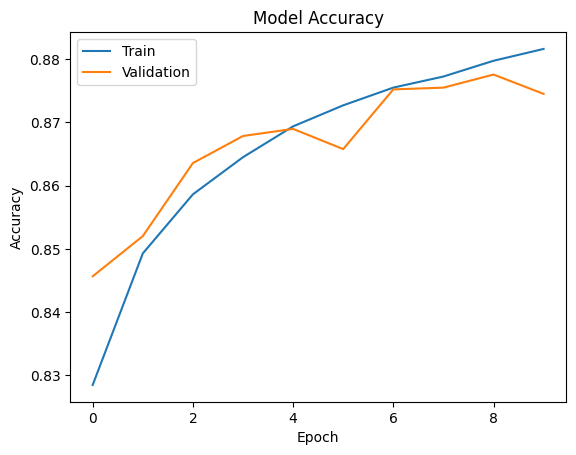

In [14]:
model_train[['accuracy','val_accuracy']].plot()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()


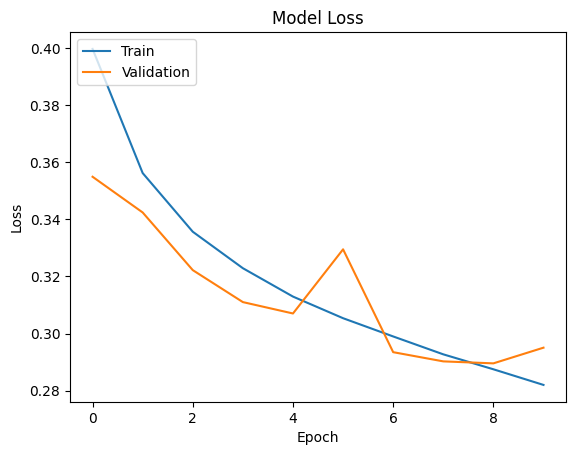

In [15]:
model_train[['loss','val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()